
Using the best AD input parameters found by the Find_Events.ipynb script,
load the results, find the corresponding start and end times for runoff events,
query for any missing radar images, and batch mask the images to yield
just the pixels representing each station catchment.




In [198]:
import pandas as pd
import numpy as np
import os 
import sys
import math
import utm
import time

import json
import geopandas as gpd
import fiona
from geopy import distance

from numba import jit

import codecs

from shapely.geometry import shape, mapping, Polygon

from sklearn.decomposition import PCA

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from bokeh.plotting import ColumnDataSource, output_notebook
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral3
from bokeh.layouts import gridplot

from radar_scrape import get_radar_img_urls, request_img_files
from radar_station_coords import radar_sites
from get_station_data import get_daily_runoff
output_notebook()

Loading BokehJS ...

In [199]:
radar_stations = radar_sites

In [200]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(''))))
DB_DIR = os.path.join(BASE_DIR, 'code/hydat_db')
PROJECT_DIR = os.path.abspath('')
# IMG_DIR = os.path.join(PROJECT_DIR, 'data/radar_img')
RADAR_IMG_DIR = os.path.join(PROJECT_DIR, 'data/sorted_radar_images')

RESULTS_DIR = os.path.join(PROJECT_DIR, 'data/AD_results')


In [201]:
stations_df = pd.read_csv(DB_DIR + '/WSC_Stations_Master.csv')
stations_df['RADAR_Overlap'] = stations_df['Year To'].astype(int) - 2007

In [202]:
print(stations_df.columns)

Index(['Station Number', 'Station Name', 'Province', 'Status', 'Latitude',
       'Longitude', 'Year From', 'Year To', 'Gross Drainage Area (km2)',
       'Effective Drainage Area (km2)', 'Regulation', 'Data Type',
       'Operation Schedule', 'Sediment', 'RHBN', 'Real-Time', 'Datum Name',
       'Publishing Office', 'Operating Agency', 'Contributed', 'Elevation',
       'RADAR_Overlap'],
      dtype='object')


In [203]:
stations_filtered = stations_df[stations_df['RADAR_Overlap'] > 0]

In [204]:
stations_filtered = stations_filtered[stations_filtered['Regulation'] == 'N']

In [205]:
stations_filtered.rename(columns={'Gross Drainage Area (km2)': 'DA'}, inplace=True)
stations_filtered = stations_filtered[(stations_filtered['Province'] == 'BC') | (stations_filtered['Province'] == 'AB')]

In [206]:
def find_closest_radar_stn(row):
    """
    To retrieve radar images, we need to find the closest radar location
    to the station of interest.  
    Input the station number,
    returns the location code of the nearest radar station.
    """
    stn_data = row['Station Number']
    
    s1 = (row['Latitude'], row['Longitude'])
    min_dist = 1E6
    closest_stn = None
    for site in radar_stations.keys():

        s2 = [*radar_stations[site]['lat_lon']]        

        this_dist = distance.distance(s2, s1).km
    
        if this_dist < min_dist:
            min_dist = this_dist
            closest_stn = site
        
    return closest_stn

def calc_distance(row):
    wsc_stn_coords = (row['Latitude'], row['Longitude'])
    radar = row['Closest_radar']
    radar_coords = radar_stations[radar]['lat_lon']
    return distance.distance(radar_coords, wsc_stn_coords).km

from shapely.geometry import Point

def calculate_distance(row):
    wsc_stn_coords = [row['Latitude'], row['Longitude']]
    radar = row['Closest_radar']
   
    radar_coords = radar_stations[radar]['lat_lon']

    d = distance.distance(radar_coords, wsc_stn_coords).km
    return d


In [207]:
# filter for stations within 200 km of the radar <sigh>
stations_filtered['Closest_radar'] = stations_filtered.apply(lambda row: find_closest_radar_stn(row), axis=1)
stations_filtered['Dist_to_radar'] = stations_filtered.apply(lambda row: calculate_distance(row), axis=1)
# print(stations_filtered['Dist_to_radar'].head())
print(len(stations_filtered))


601


In [208]:
stations_filtered = stations_filtered[stations_filtered['Dist_to_radar'] < 200]
print(len(stations_filtered))

262


In [209]:
stn_df = stations_filtered[np.isfinite(stations_filtered['DA'].astype(float))]
stn_df = stn_df[stn_df['DA'].astype(float) >= 10]
stn_df = stn_df[stn_df['DA'].astype(float) < 1000].sort_values('DA')
# print(stn_df[stn_df['Station Number'] == '08HB048'])

In [210]:
print(sorted(stn_df['Station Number'].values))

['05AA004', '05AA008', '05AA022', '05AA027', '05AA030', '05AA033', '05AA909', '05AB005', '05AB013', '05AB029', '05AB040', '05AC030', '05AD035', '05BA001', '05BG006', '05BH013', '05BH014', '05BJ004', '05BK001', '05BL013', '05BL014', '05BL019', '05BL022', '05BL023', '05BL027', '05BM014', '05BM018', '05CA002', '05CA004', '05CA011', '05CA012', '05CB002', '05CB004', '05CC008', '05CC009', '05CC010', '05CC011', '05CC013', '05CD006', '05CD007', '05CD913', '05CE006', '05CE010', '05CE011', '05CE012', '05CE018', '05CG004', '05CG006', '05CK001', '05CK007', '05DB002', '05DB005', '05FA014', '05FA024', '05FC002', '05FC004', '05FC007', '05GA011', '07EE009', '08GA072', '08GA075', '08GA077', '08GA079', '08GB013', '08GB014', '08HA001', '08HA003', '08HA010', '08HA016', '08HA070', '08HB002', '08HB014', '08HB024', '08HB025', '08HB032', '08HB048', '08HB074', '08HB075', '08HB086', '08HB089', '08HC002', '08HD011', '08HD015', '08HD023', '08JE004', '08KA001', '08KA009', '08KB006', '08KE024', '08KH010', '08KH019'

In [211]:
df = stn_df[['Province', 'Station Number', 'Station Name', 'DA', 'Elevation', 'Latitude', 'Longitude', 'RADAR_Overlap']]
print('After filtering, there are {} candidate stations.'.format(len(stn_df)))

After filtering, there are 162 candidate stations.


In [212]:
# retrieve the results dataframe for the specified site
results_folders = os.listdir(RESULTS_DIR)

results_dict = {}

folder_path = os.path.join(RESULTS_DIR, 'sample_200')
all_sites = [e.split('_')[0] for e in os.listdir(folder_path)]
results_dict = {site: pd.read_csv(os.path.join(folder_path, site + '_results.csv')) for site in all_sites}

def get_best_result(site):
    ad_df = pd.DataFrame(results_dict[site])
    ad_df.drop(labels='Unnamed: 0', inplace=True, axis=1)
    ad_df.sort_values('len_results', inplace=True, ascending=False)
    return ad_df.iloc[0, :]



In [254]:
test_stn = stn_df['Station Number'].values[23]

best_result = get_best_result(test_stn)

test_stn_info = stn_df[stn_df['Station Number'] == test_stn]

test_stn_name = test_stn_info['Station Name'].values[0]
test_stn_da = test_stn_info['DA'].values[0]
print('Station {} ({}) has a DA of {} km^2'.format(test_stn, test_stn_name, test_stn_da))

Station 08MH141 (COQUITLAM RIVER ABOVE COQUITLAM LAKE) has a DA of 52.5 km^2


In [255]:
df = get_daily_runoff(test_stn)
df['Year'] = df.index.year
df['Month'] = df.index.month

In [256]:
# filter by minimum radar date
df = df[df.index > pd.to_datetime('2007-05-31')]

In [257]:
df['Date'] = df.index.values

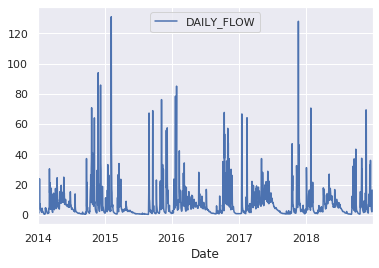

In [258]:
df[df['Year'] > 2013].plot('Date', 'DAILY_FLOW')

In [259]:
# from peak_detection import find_peaks

In [260]:
def find_peaks(data, lag=7, threshold=500, influence=0.5):
    # Settings (the ones below are examples: choose what is best for your data)
#     lag = 5         # lag 5 for the smoothing functions
#     threshold = 3.5  # 3.5 standard deviations for signal
#     influence = 0.5  # between 0 and 1, where 1 is normal influence, 0.5 is half
    # Initialize variables
    signals = np.zeros(len(data))            # Initialize signal results
    filteredY = np.empty(len(data))
    filteredY[:lag] = data[:lag]             # Initialize filtered series
    avgFilter = [0]                          # Initialize average filter
    stdFilter = [0]                          # Initialize std. filter
    avgFilter = {lag: np.mean(data[:lag])}      # Initialize first value
    stdFilter = {lag: np.std(data[:lag])}     # Initialize first value
    
    for i in range(lag + 1, len(data)):
        d = data[i]
        
        af = avgFilter[i-1]
        sf = stdFilter[i-1]
        
        if abs(d - af) > threshold * sf:
            if d > af:
                signals[i] = 1                     # Positive signal
            else:
                signals[i] = -1                    # Negative signal

            
            filteredY[i] = influence*d + (1-influence)*filteredY[i-1]
        else:
            signals[i] = 0                        # No signal
            filteredY[i] = 0
        
        
        # Adjust the filters
        avgFilter[i] = np.mean(filteredY[i-lag:i])
        stdFilter[i] = np.std(filteredY[i-lag:i])
        
    return signals, filteredY

n_test = 500

dats = list(df['DAILY_FLOW'].to_numpy())
sigs, f_dat = find_peaks(dats, influence=0.75, lag=7, threshold=5)

/home/danbot/Documents/code/cuda_env/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [276]:
from bokeh.plotting import figure, output_file, show, output_notebook

input_sig = df[['DAILY_FLOW']].copy()
signal = np.array(sigs)
input_sig['sig'] = signal.copy().astype(int)
input_sig['f_sig'] = f_dat

foo = input_sig[input_sig['sig'] == 1].copy()
p = figure(plot_width=800, plot_height=400, x_axis_type='datetime')
# add a circle renderer with a size, color, and alpha
p.circle(foo.index, foo['DAILY_FLOW'], size=10, color="red", 
         alpha=0.5, legend_label='{} pts'.format(len(foo)))
# p.line(input_sig.index, input_sig['f_sig'], color='blue')
p.line(input_sig.index, input_sig['DAILY_FLOW'], color='blue')
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Flow [cms]'
# p.line()
# show the results
show(p)

Find the summer baseflow

Break up the May to November records by periods where it comes back to within X% of baseflow.  

check durations of these periods, see how many there are.

In [262]:
# Based on code from Anomaly detection ML methods article:
# https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770

# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

In [263]:
def create_lag_df(flow_df, stn_da):

    lag_df = flow_df.copy()
    
    lag_df.rename(columns={'DAILY_FLOW': 'Q'}, inplace=True)

    num_lags = int(np.ceil(stn_da / 100) + 5)

    for i in range(1,num_lags):
        lag_df['Q{}'.format(i)] = lag_df['Q'].shift(i)

    lag_df.dropna(inplace=True)
    
    return lag_df, num_lags

In [264]:
def initialize_wsc_station_info_dataframe():
    # import master station list
    stations_df = pd.read_csv(DB_DIR + '/WSC_Stations_Master.csv')
    # filter for stations that have concurrent record with the historical radar record
    stations_df['RADAR_Overlap'] = stations_df['Year To'].astype(int) - 2007
    stations_filtered = stations_df[stations_df['RADAR_Overlap'] > 0]
    # filter for stations that are natural flow regimes
    stations_filtered = stations_filtered[stations_filtered['Regulation'] == 'N']
    stations_filtered.rename(columns={'Gross Drainage Area (km2)': 'DA'}, inplace=True)
    # filter for stations in Alberta and British Columbia
    stations_filtered = stations_filtered[(stations_filtered['Province'] == 'BC') | (stations_filtered['Province'] == 'AB')]
    
    # calculate distance to each radar station
    stations_filtered['radar_stn_distance_dict'] = stations_filtered.apply(lambda row: calculate_radar_stn_distances(row), axis=1)    
    stations_filtered['closest_radar_station'] = stations_filtered.apply(lambda row: find_closest_radar_stn(row), axis=1)
    stations_filtered['radar_distance_km'] = stations_filtered.apply(lambda row: find_closest_radar_stn_distance(row), axis=1)
    
    # radar range is a 240km radius from the station
    stations_filtered = stations_filtered[stations_filtered['radar_distance_km'] < 190]
    stn_df = stations_filtered[np.isfinite(stations_filtered['DA'].astype(float))]
    # filter for stations greater than 10 km^2 (too small for meaningful results)
    stn_df = stn_df[stn_df['DA'].astype(float) >= 10]
    # filter for stations smaller than 1000 km^2 (too large and complex)
    stn_df = stn_df[stn_df['DA'].astype(float) < 1000].sort_values('DA')
    df = stn_df[['Province', 'Station Number', 'Station Name', 'DA', 
                 'Elevation', 'Latitude', 'Longitude', 'RADAR_Overlap',
                'closest_radar_station', 'radar_stn_distance_dict', 'radar_distance_km']]
#     print('After filtering, there are {} candidate stations.'.format(len(stn_df)))
    df.reset_index(inplace=True)
    return df


In [265]:
def find_closest_radar_stn(row):
    """ 
    Input the dict of all station distances,
    Return the location code of the nearest radar station.
    """
    radar_station_distances = row['radar_stn_distance_dict']
    min_dist = min(radar_station_distances.items(), key=lambda x: x[1])
    return min_dist[0]


def find_closest_radar_stn_distance(row):
    """ 
    Input the dict of all station distances,
    Return the location code of the nearest radar station.
    """
    radar_station_distances = row['radar_stn_distance_dict']
    min_dist = min(radar_station_distances.items(), key=lambda x: x[1])
    return min_dist[1]

def calc_distance(wsc_row, radar_station):
    wsc_stn_coords = (wsc_row['Latitude'], wsc_row['Longitude'])
    radar_coords = radar_stations[radar_station]['lat_lon']
    return distance.distance(radar_coords, wsc_stn_coords).km

def calculate_all_distances(row, radar_site):
    wsc_stn_coords = [row['Latitude'], row['Longitude']]
    
    radar_coords = radar_stations[radar_site]['lat_lon']
    xs = [wsc_stn_coords[1], radar_coords[1]]
    ys = [wsc_stn_coords[0], radar_coords[0]]

    geom = [Point(xy) for xy in zip(xs, ys)]
    gdf = gpd.GeoDataFrame(geometry=geom, crs='epsg:4326')
    gdf.to_crs(epsg=3310, inplace=True)
    # calculate distance in kilometers
    l = gdf.distance(gdf.shift()).values[-1] / 1000
    return l


In [266]:
def calculate_radar_stn_distances(row):
    distance_dict = {}
    for site in radar_stations:
        distance_dict[site] = calculate_all_distances(row, site)
    return distance_dict

def split_train_and_test_data(data, training_months, training_year):
    time_range_check = (data.index.year == training_year) & (data.index.month.isin(training_months))
    train_data = data[time_range_check]
    # the test data is the entire dataset because we want to extract
    # extreme events from the training year as well
    test_data = data
    return train_data, test_data

In [267]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [268]:
def initialize_runoff_dataframe(test_stn):
    
    runoff_df = get_daily_runoff(test_stn)
    runoff_df['Q'] = runoff_df['DAILY_FLOW']
    runoff_df = runoff_df[['Q']]
#     runoff_df['Year'] = runoff_df.index.year
#     runoff_df['Month'] = runoff_df.index.month
    
    # filter by minimum radar date
    runoff_df = runoff_df[runoff_df.index > pd.to_datetime('2007-05-31')]
    
#     runoff_df['Date'] = runoff_df.index.values
    
    return runoff_df


In [269]:
def do_PCA(X_train, X_test, n_components):
    
    for n_components_kept in range(2, n_components + 1):

        pca = PCA(n_components=n_components_kept, svd_solver= 'full')
        X_train_PCA = pca.fit_transform(X_train)
        X_train_PCA = pd.DataFrame(X_train_PCA)
        X_train_PCA.index = X_train.index

        X_test_PCA = pca.transform(X_test)
        X_test_PCA = pd.DataFrame(X_test_PCA)
        X_test_PCA.index = X_test.index

        var_expl = 100*np.sum(pca.explained_variance_ratio_)
        if var_expl >= 90:
#             print('var > 0.9 in {} components'.format(n_components_kept))
            return X_train_PCA, X_test_PCA, var_expl, n_components_kept
#     print('var < 0.9 in {} components'.format(n_components_kept))
    return X_train_PCA, X_test_PCA, var_expl, n_components_kept

In [270]:
def train_model(training_params):
    
    months_str = training_params['train_months'][1:-1]
    
    if len(months_str) == 4:
        training_months = [int(months_str.split(',')[0])]
    elif len(months_str) == 2:
        training_months = [int(months_str[0])]
    else:
        training_months = [int(e) for e in months_str.split(', ')]
        
    training_year = training_params['train_year']
#     training_set_len = input_array[2]
    wsc_station_num = training_params['wsc_stn']
    stn_da = stn_df[stn_df['Station Number'] == wsc_station_num]['DA'].values[0]
    training_sample_size = training_params['n_sample']
    
#     print('Initializing input data...')
    
    closest_radar_stn = training_params['radar_stn']
    
    runoff_df = initialize_runoff_dataframe(wsc_station_num)   
    
    lag_df, num_lags = create_lag_df(runoff_df, stn_da)

#     lag_df, closest_radar_stn, runoff_df, num_lags = initialize_input_data(wsc_station_num)
#     print('Splitting input flow series into training and test sets...')
    dataset_train, dataset_test = split_train_and_test_data(lag_df, training_months, training_year)
        
    training_set_len = len(dataset_train)
    
    if len(dataset_train) < 2:
        print('exited because dataset_train is too small')
#         print(dataset_train)
        return pd.DataFrame([]), 0

    scaler = preprocessing.MinMaxScaler()

    X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                                  columns=dataset_train.columns, 
                                  index=dataset_train.index)
    # Random shuffle training data
    X_train.sample(frac=1)

    X_test = pd.DataFrame(scaler.transform(dataset_test), 
                                 columns=dataset_test.columns, 
                                 index=dataset_test.index)
    
#     print('Perform PCA on the lagged runoff series matrix...')
    X_train_PCA, X_test_PCA, var_expl, n_components = do_PCA(X_train, X_test, num_lags)
    
    data_train = np.array(X_train_PCA.values)
    data_test = np.array(X_test_PCA.values)
    
    def cov_matrix(data, verbose=False):
        covariance_matrix = np.cov(data, rowvar=False)
        if is_pos_def(covariance_matrix):
            inv_covariance_matrix = np.linalg.inv(covariance_matrix)
            if is_pos_def(inv_covariance_matrix):
                return True, covariance_matrix, inv_covariance_matrix
            else:
                print("Error: Inverse of Covariance Matrix is not positive definite!")
                return False, None, None
        else:
            print("Error: Covariance Matrix is not positive definite!")
            return False, None, None

               
    cov_test, cov_matrix, inv_cov_matrix = cov_matrix(data_train)
    
    if cov_test == False:
        return pd.DataFrame([]), 0

    mean_distr = data_train.mean(axis=0)

    dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
    dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
    threshold = MD_threshold(dist_train, extreme = True)
    
    anomaly_train = pd.DataFrame()
    anomaly_train['Mob dist']= dist_train
    anomaly_train['Thresh'] = threshold
    # If Mob dist above threshold: Flag as anomaly
    anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
    anomaly_train.index = X_train_PCA.index
    anomaly = pd.DataFrame()
    anomaly['Mob dist']= dist_test
    anomaly['Thresh'] = threshold
    anomaly['num_components_kept'] = n_components
    # If Mob dist above threshold: Flag as anomaly
    anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
    anomaly.index = X_test_PCA.index
    anomaly.head()
    
    anomaly_alldata = pd.concat([anomaly_train, anomaly], sort=True)
    
    event_times = np.where(anomaly_alldata['Anomaly'].values[:-1] != anomaly_alldata['Anomaly'].values[1:])[0]
    events = pd.merge(lag_df, anomaly_alldata.iloc[event_times,:], how='inner', 
                      left_index=True, right_index=True)

    events = events.loc[~events.index.duplicated(keep='first')]
    
    if len(events) == 0:
        print('exited because len(events) == 0')
        return pd.DataFrame([]), 0
    elif events.iloc[0]['Anomaly'] == True:
        events = events.iloc[1:]
        
    # create a column of time difference between events in days
    events['dt_days'] = events.index.to_series().diff(1)    

    a = time.time()

    last_event_end = False

    new_events = pd.DataFrame()

    # iterate through the detected event pairs 
    for i in np.arange(0, len(events) - 1, 2):
        # parse a single event pair
        this_event = events.iloc[i:i+2]
        
        check_sign_switch = this_event['Anomaly'].values[0] != this_event['Anomaly'].values[1]
        concurrent_wsc = lag_df[(lag_df.index >= this_event.index.values[0]) & (lag_df.index <= this_event.index.values[1])][['Q']]
        peak_in_middle = check_peak_in_middle(this_event, concurrent_wsc)

        if (check_sign_switch) & (peak_in_middle):

            # get the start date
            this_event_start = pd.to_datetime(this_event[this_event['Anomaly'] == False].index.values[0])
            # get the end date
            this_event_end = pd.to_datetime(this_event[this_event['Anomaly'] == True].index.values[0])

            new_event_start = lag_df[lag_df.index == this_event_start][['Q']]
            new_event_end = lag_df[lag_df.index == this_event_end][['Q']]

            adjusted_start_date = pd.to_datetime(adjust_edge_date(this_event_start, lag_df[['Q']], 'start'))

            new_event_start = lag_df[lag_df.index == adjusted_start_date][['Q']]

            if last_event_end is not False:

                # find if the start date is on the rising limb - adjust if so
                if adjusted_start_date < last_event_end:
                    new_event_start = lag_df[lag_df.index == this_event_start][['Q']]

            new_event_start['timing'] = 'start'
            new_event_end['timing'] = 'end'

            min_time_check = (new_event_end.index - new_event_start.index).days > 1
            max_time_check = (new_event_end.index - new_event_start.index).days <= 14
            start_month = new_event_start.index.month
            end_month = new_event_end.index.month
            season_check = (start_month > 5) & (start_month < 11) & (end_month <= 11)

            if (min_time_check) & (max_time_check) & (season_check):
                new_events = new_events.append(new_event_start)
                new_events = new_events.append(new_event_end)

            last_event_end = pd.to_datetime(this_event_end)


    b = time.time()
#     print(b - a)

    new_events.sort_index(inplace=True)
    

    new_events['dt_days'] = new_events.index.to_series().diff(1)
    new_events['wsc_station'] = wsc_station_num
    new_events['training_year'] = training_year
    new_events['training_months'] = [training_months for n in range(len(new_events))]
    new_events['training_set_len'] = training_set_len
    new_events['m_threshold'] = threshold
    new_events['var_explained'] = var_expl
    new_events['n_components'] = n_components
    new_events['num_lags'] = num_lags
                
    return new_events, n_components


In [271]:
def adjust_edge_date(initial_date, data, direction):
    """
    If the start flow is on a rising limb, adjust the start to the start of the runoff event.
    """
    initial_val = data[data.index == initial_date]['Q']

    if direction == 'end':
        search_criteria = (data.index <= initial_date + pd.Timedelta('7 days')) & (data.index >= initial_date)
        search_direction = -1
    elif direction == 'start':
        search_criteria = (data.index >= initial_date - pd.Timedelta('7 days')) & (data.index <= initial_date)
        search_direction = 1
        
        
    extended_week_vals = data[search_criteria][['Q']]
    extended_week_vals['diff'] = extended_week_vals.diff(periods=search_direction)
    extended_week_vals['pct_change'] = 100 * extended_week_vals['diff'] / extended_week_vals['Q']

    if direction == 'start':
        try:
            extended_week_vals.at[extended_week_vals.index.min(),'diff'] = -1
            change_point_row = extended_week_vals[['pct_change']].idxmax()
            if len(change_point_row) > 1:
                change_point_date = extended_week_vals.loc[change_point_row - pd.DateOffset(1)].index.values[0]
                adjusted_date = change_point_date
            else:
                adjusted_date = initial_date
            
        except ValueError as err:
#                 print(err)
#                 print('no change')
            adjusted_date = initial_date

    elif direction == 'end':
#             adjusted_dates.append(s)
        try:
            change_point = extended_week_vals[extended_week_vals['diff'] < 0][['Q']].idxmin().values[0]
            adjusted_dates = change_point
#                 print(s, change_point)

        except ValueError as err:
#                 print(extended_week_vals['Q'].min())
            change_point = extended_week_vals[extended_week_vals['Q'] == extended_week_vals['Q'].min()].index.values[0]
#                 print(err)
#                 print('no change')
            adjusted_date = change_point

            
    return pd.to_datetime(adjusted_date)

def check_peak_in_middle(event, data):
    """
    Ensure there is a peak between the start and end points
    so we aren't targeting a non-runoff event.
    """
    start_time = event.index.values[0] 
    end_time = event.index.values[-1]
    max_time = data[data['Q'] == data['Q'].max()].index.values[0]
    if (max_time == start_time) | (max_time == end_time):
        return False
    else:
        return True

## Code to test a single station and view AD results

In [272]:
def run_AD_from_results(test_stn):

    test_flow_df = get_daily_runoff(test_stn)
    test_flow_df = test_flow_df[test_flow_df.index.year >= 2007]
    test_flow_df.rename(columns={'DAILY_FLOW': 'Q'}, inplace=True)
    test_flow_df = test_flow_df[['Q']]

    closest_radar_stn = stn_df[stn_df['Station Number'] == test_stn]['Closest_radar'].values[0]

    best_training_params = get_best_result(test_stn)

    n_sample = best_training_params['n_sample']
    
    best_events, msg = train_model(best_training_params)

    return best_events, test_flow_df, closest_radar_stn


# print(best_training_params)
best_events, test_flow_df, closest_radar_stn = run_AD_from_results(test_stn)

In [273]:
p = figure(plot_width=800, plot_height=400, x_axis_type='datetime')

e1 = best_events[best_events['timing'] == 'start']
e2 = best_events[best_events['timing'] == 'end']

p.circle(e1.index, e1['Q'], color='red', alpha=0.5, size=10, legend_label='start')
p.circle(e2.index, e2['Q'], color='blue', alpha=0.5, size=10, legend_label='end')

# p.line(input_sig.index, input_sig['f_sig'], color='blue')
p.line(test_flow_df.index, test_flow_df['Q'], color='blue')
# p.line()
# show the results
show(p)

In [43]:
# create grid plot of individual events

plots = []

for i in np.arange(0, len(best_events) - 1, 2):
    
    # parse a single event pair
    this_event = best_events.iloc[i:i+2]
    
    s1 = figure(background_fill_color="#fafafa", x_axis_type='datetime')
    
    s1.circle(this_event.index, this_event['Q'], 
              size=12, alpha=0.8, color="red")#, legend_label='{estimated endpoints}')
    s1.xaxis.major_label_orientation = math.pi/2
    this_start = pd.to_datetime(this_event.index.values[0])
    this_end = pd.to_datetime(this_event.index.values[1])
    this_dat = test_flow_df[(test_flow_df.index >= this_start) & (test_flow_df.index <= this_end)][['Q']]
    
    if (this_end.month < 12) & (this_start.month > 5):
        year = this_event.index.year.values[0]
        month = this_event.index.month.values[0]
        day = this_event.index.day.values[0]
        date = '{}-{}-{}'.format(year, month, day)
        s1.line(this_dat.index, this_dat['Q'], color='blue')
        plots.append(s1)

print('there are {} plots'.format(len(plots)))

there are 5 plots


In [44]:
# if len(plots) < 6:
#     grid = gridplot(plots, plot_width=150, plot_height=150)
# else:
n_cols = 8
n_rows = int(np.ceil(len(plots) / n_cols))


g = []
for i in range(0, len(plots), n_cols):
    g += [plots[i:i+n_cols]]
grid = gridplot(g, plot_width=150, plot_height=150)

In [274]:
show(grid)

## Code to batch process all station events and aquire corresponding radar images

In [47]:
def get_all_event_pairs(best_events):
    event_pairs = []
    for i in np.arange(0, len(best_events) - 1, 2):
        # parse a single event pair
        this_event = best_events.iloc[i:i+2]
        date_pair = [e.astype(str).replace('T', ' ').split('.')[0].split(' ')[0] for e in this_event.index.values]
        this_start = pd.to_datetime(this_event.index.values[0])
        this_month = this_start.month
        if (this_month > 5) & (this_month <= 11) & (this_start > pd.to_datetime('2007-01-01')):
            event_pairs.append(date_pair)
    return event_pairs

In [48]:
i = 0
for stn in all_sites: 
    i += 1
    best_events, test_flow_df, closest_radar_stn = run_AD_from_results(stn)
    event_pairs = get_all_event_pairs(best_events)
    all_img_urls = get_radar_img_urls(event_pairs, closest_radar_stn)
    n_images = len(all_img_urls)
    print('{} of {}: {} image files to query for {} with {} events identified.'.format(i, len(all_sites), 
                                                                                       len(all_img_urls), stn, 
                                                                                       len(event_pairs)))
    time0 = time.time()    
    request_img_files(all_img_urls, stn, closest_radar_stn)
    time1 = time.time()    
    print('    {:.0f}s to query all images'.format(time1 - time0))

1 of 141: 0 image files to query for 08NM173 with 23 events identified.
For 08NM173 there are 0 images to be requested from the CASSS radar station.
    0s to query all images
2 of 141: 0 image files to query for 08NN023 with 6 events identified.
For 08NN023 there are 0 images to be requested from the CASSS radar station.
    0s to query all images
3 of 141: 0 image files to query for 05CB004 with 13 events identified.
For 05CB004 there are 0 images to be requested from the CASSM radar station.
    0s to query all images
4 of 141: 0 image files to query for 08GB014 with 2 events identified.
For 08GB014 there are 0 images to be requested from the CASSI radar station.
    0s to query all images
5 of 141: 0 image files to query for 05BL013 with 11 events identified.
For 05BL013 there are 0 images to be requested from the CASSM radar station.
    0s to query all images
6 of 141: 0 image files to query for 08ND012 with 16 events identified.
For 08ND012 there are 0 images to be requested fro

KeyboardInterrupt: 

### Load Radar, Mask with Catchment, and Clip all Retrieved Images

First, make sure basin geometry is available before requesting all images.

# TODO:



## Further Work

Find all the stations that have radar overlap.  

Find a bunch of concurrent runoff events, and estimate the error based on the overlapping radar info.

In [49]:
def get_ubc_polygon():
    points = [-123.1876189229259,49.27349631820059, -123.2168376964195,49.27886813665509,
              -123.250951627253,49.28123248845857, -123.2686880871375,49.26628206996413, 
              -123.2577985144227,49.25107796072373, -123.2296736741512,49.23345938143058, 
              -123.2086850019333,49.22474925352834, -123.1911799345363,49.22020024319045, 
              -123.1852881427934,49.2196036807795, -123.1876189229259,49.27349631820059, ]
    lat_list = []
    lon_list = []
    for i in range(0, len(points), 2):
        lat_list.append(points[i])
        lon_list.append(points[i + 1])
#     gdb_path = os.path.join(PROJECT_DIR, path)
#     data = gpd.read_file(gdb_path, driver='kmz')
#     return data.geometry
    minx = min(lat_list)
    maxx = max(lat_list)
    miny = min(lon_list)
    maxy = max(lon_list)
    bbox = pd.DataFrame({'minx': [minx], 'miny': [miny],
                        'maxx': [maxx], 'maxy': [maxy]})
    return Polygon(zip(lat_list, lon_list)), bbox

In [46]:
import shapely.speedups
shapely.speedups.enable()

In [47]:
def mask_images_and_save(gif_images, mask, test_stn, best_radar_stn):
    print(best_radar_stn)
    origin_path = os.path.join(RADAR_IMG_DIR, best_radar_stn)
    save_path = os.path.join(PROJECT_DIR, 'data/masked_img/{}'.format(test_stn))
    for t_img in gif_images:
        new_filename = t_img.split('.')[0] + '_crp.gif'
        time0 = time.time()      
        origin_full_path = os.path.join(origin_path, t_img)
        new_file_path = os.path.join(save_path, new_filename)
        # there are a large number of empty images that get returned
        # from image retrievel.  DON'T DELETE THEM or you will 
        # request them many times over in the AD function.
        # Instead, filter them out here.
        if os.path.getsize(origin_full_path) > 100:
            gif_img = Image.open(origin_full_path).convert('RGB')
            img_array = np.asarray(gif_img)[:,:480].astype(np.uint8)        
            filtered_img = mask_image(img_array, mask)
            time1 = time.time()
            try:
                cropped_array = bbox2(filtered_img)
                cropped_img = Image.fromarray(cropped_array.astype(np.uint8))
                cropped_img.save(os.path.join(save_path, new_filename))
            except Exception as e:
                print('Something broke in the image mask process for {}'.format(test_stn))
                print(e)
                break


def get_event_times(df):
    event_pairs = []
    for i in np.arange(0, len(df) - 1, 2):    
        # parse a single event pair
        this_event = df.iloc[i:i+2]
        date_pair = [e.astype(str).replace('T', ' ').split('.')[0].split(' ')[0] for e in this_event.index.values]
        this_start = pd.to_datetime(this_event.index.values[0])
        this_month = this_start.month
        if (this_month > 5) & (this_month <= 11) & (this_start > pd.to_datetime('2007-01-01')):
            event_pairs.append(date_pair)
    return event_pairs
    
    
def get_possible_filenames_from_event_time(event_pair):
    filenames = []
    for p in event_pair:
        start, end = p[0], p[1]
        datetime_range = [str(pd.to_datetime(e).strftime('%Y%m%d%H%M')) + '.gif' for e in pd.date_range(pd.to_datetime(start), 
                                       pd.to_datetime(end),
                                      freq='1H').values]
        filenames += datetime_range
    return set(filenames)


def get_radar_images_for_events(wsc_stn, radar_stn, best_events):
    event_df = best_events
    event_pairs = get_event_times(event_df)
    
    files_to_search = get_possible_filenames_from_event_time(event_pairs)
    
    existing_files = os.listdir(os.path.join(RADAR_IMG_DIR, radar_stn))
    
#     new_files = np.setdiff1d(files_to_search, existing_files)
    new_files = files_to_search.intersection(existing_files)
    return new_files


def get_gif_images(test_stn, closest_radar_stn, best_events):
    gif_path = 'data/sorted_radar_images/{}'.format(closest_radar_stn)
    save_path = 'data/masked_img/{}'.format(test_stn)
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    return list(get_radar_images_for_events(test_stn, closest_radar_stn, best_events))

In [52]:

def get_pixel_coordinates(closest_stn):
    # note that the pixel coordinates are projected to NAD83
    # coordinate system and when I figure out 
    # how to re-project without 20km error I will
    # try to estimate the error accordingly.
    img_coord_path = 'data/radar_img_pixel_coords'
    img_coord_file = [f for f in os.listdir(img_coord_path) if closest_stn in f][0]
    geo_df = gpd.read_file(os.path.join(img_coord_path, img_coord_file))
#     print('what is this?')
#     print(geo_df.crs)
#     geo_df = geo_df.to_crs('EPSG:3153')
    
    return geo_df


def get_img_mask(closest_stn, basin_geom, wsc_stn):
    # take in the basin geometry and its corresponding radar station
    # return a 480x480 boolean matrix where True represents
    # pixels that fall within the basin polygon
    # note that the points are stored in (lat, lon) tuples
    # which corresponds to y, x
#     print('pulling geometries together...')
    basin_geom = basin_geom.to_crs('epsg:4326')
    print('Basin polygon crs: ', basin_geom.crs)
    print('bason bounds')
    print(basin_geom.bounds)
#     print('basin geom bounds:')
#     print(basin_geom.bounds)
    basin_geom_data = basin_geom.geometry
#     print(basin_geom_data)
    
    mask_folder = 'data/wsc_stn_basin_masks'
    mask_path = os.path.join(PROJECT_DIR, mask_folder)
    mask_filename = wsc_stn + '.json'
    existing_masks = os.listdir(mask_path)

#     if mask_filename in existing_masks:
#         return pd.read_json(os.path.join(mask_path, mask_filename)).to_numpy()
#     else:
#         print('No image mask exists.  Try creating one...')
    geo_df = get_pixel_coordinates(closest_stn)#.to_numpy().flatten()

    # match the crs of the basin polygon
#     geo_df = geo_df.to_crs('EPSG:4326')
#     geo_df = geo_df.to_crs('EPSG:3153')
    
    print('Image crs: ', geo_df.crs)
    print('image geo_df bounds')
    print(geo_df.total_bounds)
#     print('...')
    
    pip_mask = geo_df.within(basin_geom.loc[0, 'geometry'])
    
    reshaped_mask = np.array(pip_mask).reshape(480, 480)

    img_mask_df = pd.DataFrame(reshaped_mask)

    img_mask_df.to_json(os.path.join(mask_path, mask_filename), orient='columns')
    
    print('saved json')


def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return img[ymin:ymax+1, xmin:xmax+1]


@jit
def mask_image(img_array, mask):
    mask_idx = np.where(mask==0)
    rows = mask_idx[0]
    cols = mask_idx[1]
    filtered_img = np.zeros((480, 480, 3))
    for n in range(480):
        for m in range(480):
            if mask[n, m] == 0:
                filtered_img[n, m] = 0
            else:
                filtered_img[n, m] = img_array[n, m]
    return filtered_img

In [53]:
def create_mask(wsc_stn):
    
    best_events, test_flow_df, closest_radar_stn = run_AD_from_results(wsc_stn)
    event_pairs = get_all_event_pairs(best_events)
    
    print('closest radar = ', closest_radar_stn)
    
    stn_da = stn_df[stn_df['Station Number'] == wsc_stn]['DA'].values[0]
    
    try:
        basin_geom = get_basin_geometry(wsc_stn)
    except ValueError as err:
        print('No basin geometry available for {}.'.format(wsc_stn))
        return None
#     closest_radar_stn = stn_df[stn_df['Station Number'] == wsc_stn]['Closest_radar'].values[0]
    print('Retrieve image mask...')
    t0 = time.time()
    mask = get_img_mask(closest_radar_stn, basin_geom, wsc_stn)
    t1 = time.time()
    print('Image mask retrieved in {:.1f} s.'.format(t1 - t0))


In [57]:
def get_polygon(stn):
    gdb_path = os.path.join(DB_DIR, 'WSC_Basins.gdb.zip')
    data = gpd.read_file(gdb_path, driver='FileGDB', layer='EC_{}_1'.format(stn))
    return data

def get_basin_geometry(test_stn):
    basin_geom = get_polygon(test_stn)
    # reproject to EPSG: 3395 (mercator) for plotting
    # or to coincide with radar image coordinates use
    # original WSC basin polygon is EPSG: 4269 (NAD83)
    # WGS 84 is EPSG: 4326
    basin_bbox = basin_geom.bounds
    return basin_geom

In [55]:
def run_masking_function(wsc_stn):
    
    
    best_events, test_flow_df, closest_radar_stn = run_AD_from_results(wsc_stn)
    if len(best_events) > 0:

        event_pairs = get_all_event_pairs(best_events)


    #     best_result = get_best_result(wsc_stn)
    #     runoff_df = initialize_runoff_dataframe(stn)
        stn_da = stn_df[stn_df['Station Number'] == wsc_stn]['DA'].values[0]

        gif_images = get_gif_images(wsc_stn, closest_radar_stn, best_events)
        time0 = time.time()

        mask_folder = 'data/wsc_stn_basin_masks'
        mask_path = os.path.join(PROJECT_DIR, mask_folder)
        mask_filename = wsc_stn + '.json'
        existing_masks = os.listdir(mask_path)
        if mask_filename in existing_masks:
            try:
                mask = pd.read_json(os.path.join(mask_path, mask_filename)).to_numpy()
            except ValueError as ve:
                print(wsc_stn)
                print(ve)

            mask_images_and_save(gif_images, mask, wsc_stn, closest_radar_stn)
            time1 = time.time()
            print('Time to process {} images for {}: {:.1f}s, ({:.2f}s/image)'.format(len(gif_images), 
                                                                                      wsc_stn,
                                                                                       time1-time0, 
                                                                                       (time1-time0)/len(gif_images)))
        else:
            print('No mask available for {}.'.format(wsc_stn))
    else:
        print('No results returned for {}.'.format(wsc_stn))


In [65]:
i = 0
for stn in all_sites[139:]:
    print(stn)
    i += 1
    stn_name = stn_df[stn_df['Station Number'] == stn]['Station Name'].values[0]
    print('({} / {}): Starting image masking function on station {}: {}'.format(i, len(all_sites),
                                                                               stn, stn_name))

    create_mask(stn)
    print('')



08HA003
(1 / 141): Starting image masking function on station 08HA003: KOKSILAH RIVER AT COWICHAN STATION
closest radar =  CASSI
Retrieve image mask...
Basin polygon crs:  epsg:4326
bason bounds
         minx       miny        maxx       maxy
0 -123.972341  48.593027 -123.595451  48.743098
Image crs:  epsg:4326
image geo_df bounds
[-127.1587835    46.65844007 -120.34008088   51.00973346]
saved json
Image mask retrieved in 7.7 s.

08LB069
(2 / 141): Starting image masking function on station 08LB069: BARRIERE RIVER BELOW SPRAGUE CREEK
closest radar =  CASSS
Retrieve image mask...
Basin polygon crs:  epsg:4326
bason bounds
         minx       miny        maxx       maxy
0 -120.044198  51.245371 -119.523504  51.539944
Image crs:  epsg:4326
image geo_df bounds
[-122.58159768   48.16520274 -115.53242858   52.51768467]
saved json
Image mask retrieved in 9.1 s.



In [71]:
mask_folder_path = os.path.join(PROJECT_DIR, 'data/wsc_stn_basin_masks')
all_masked_sites = [e.split('.')[0] for e in os.listdir(mask_folder_path)]


In [73]:
# test_stn = '08NE039'

# for stn in all_masked_sites:
#     run_masking_function(stn)
    
# masked_img_path = os.path.join(PROJECT_DIR, 'data/masked_img/{}'.format(test_stn))

# fig, ax = plt.subplots(figsize=(4,4))

# for m_img in os.listdir(masked_img_path)[:1]:
#     image = Image.open(os.path.join(masked_img_path, m_img))

# plt.imshow(image)
# ax.grid(False)

CASSM
Time to process 1666 images for 05BL014: 12.4s, (0.01s/image)
CASSM
Time to process 3383 images for 05CC010: 22.8s, (0.01s/image)
CASSM
Time to process 2660 images for 05CC011: 16.8s, (0.01s/image)
CASAG
Time to process 1234 images for 08MG001: 9.2s, (0.01s/image)
CASPG
Something broke in the image mask process for 07EE009
index 0 is out of bounds for axis 0 with size 0
Time to process 1928 images for 07EE009: 3.4s, (0.00s/image)
CASSS
Time to process 1356 images for 08LE027: 10.0s, (0.01s/image)
CASSM
Time to process 1645 images for 05BL027: 12.6s, (0.01s/image)
CASAG
Time to process 1840 images for 08MH016: 13.8s, (0.01s/image)
CASAG
Time to process 2227 images for 08MF062: 16.5s, (0.01s/image)
CASSS
Time to process 2938 images for 08LC040: 20.6s, (0.01s/image)
CASPG
Something broke in the image mask process for 08KB006
index 0 is out of bounds for axis 0 with size 0
Time to process 3524 images for 08KB006: 5.5s, (0.00s/image)
CASAG
Time to process 3411 images for 08ME027: 24.4

## Create image masks for all WSC stations

It takes between 1-2 minutes to create the station mask, so loading them once 
and pre-saving saves considerable time.

In [49]:
# print(stn_df[['Station Number', 'DA']].to_numpy())

In [ ]:
# this masking process takes a really long time because 
# producing the masked array is really slow.
# should try finding a better algorithm but 'union' doesn't work.
# Maybe there's a workaround?
# i = 0
# for stn in ['08NE039']:#all_sites:
#     i += 1
#     stn_name = stn_df[stn_df['Station Number'] == stn]['Station Name'].values[0]
#     print('{} of {}: Starting image masking function on station {}: {}'.format(i, len(all_sites),
#                                                                                stn, stn_name))

    
#     create_mask(stn)

    

In [ ]:
# ubc_polygon = get_ubc_polygon()

In [ ]:
# mask = get_img_mask(best_radar_stn, basin_geom)
# mask = get_img_mask('CASSS', )
# mask = get_img_mask('CASAG', ubc_polygon)

In [ ]:
# gif_images = get_gif_images(test_stn, best_radar_stn)
# gif_images = os.listdir(os.path.join(RADAR_IMG_DIR, 'CASAG'))

In [ ]:
time0 = time.time()
mask_images_and_save(gif_images, mask, test_stn, best_radar_stn)
# mask_images_and_save(gif_images, mask, 'UBC', 'CASAG')
time1 = time.time()

print('Time to process {} images: {:.1f}s, ({:.2f}s/image)'.format(len(gif_images), 
                                                                   time1-time0, 
                                                                   (time1-time0)/len(gif_images)))

In [ ]:
# open the image file

# gif_img = Image.open('data/radar_img/08HF006/200708261000.gif') # 640x480x3 array
# label = gif_img.convert('RGB')
# img_array = np.asarray(label)
# radar_img_array = np.asarray(img_array)[:,:480]
# color_bar_array = img_array[144:340, 515:535]
# color_bar_img = Image.fromarray(color_bar_array, mode='RGB')
# colors = color_bar_img.getcolors()

In [50]:
stn_lat = test_stn_info['Latitude'].values[0]
stn_lon = test_stn_info['Longitude'].values[0]

stn_coords = (stn_lon, stn_lat)[::-1]

| Item | Default Unit | Other Possible Conversions |
|---|---|---|
| Station Loc. | Lat/Lon | UTM (with zone) | None |
| Catchment Boundary | ESRI:102001 | Anything Geopandas can do |
| Satellite Radar Img. | None | Radar centre can have UTM, pixels are 1kmx1km | 

In [51]:
# format WSC station data points into a geodataframe
all_stations = stn_df['Station Number'].values



geo_df = stn_df[['Station Number', 'Latitude', 'Longitude']]
# geo_df.crs = geo_df.'EPSG:4326'
wsc_sites_geo = gpd.GeoDataFrame(geo_df, geometry=gpd.points_from_xy(geo_df['Longitude'], geo_df['Latitude']),
                                crs='EPSG:4326')
# Convert to Mercator for Plotting
wsc_sites_geo = wsc_sites_geo.to_crs("EPSG:3857")

# Get x and y coordinates
wsc_sites_geo['x'] = [geometry.x for geometry in wsc_sites_geo['geometry']]
wsc_sites_geo['y'] = [geometry.y for geometry in wsc_sites_geo['geometry']]
wsc_df = wsc_sites_geo.drop('geometry', axis = 1).copy()
sitesource = ColumnDataSource(wsc_df)

In [52]:
# format radar station data points into a geodataframe

r_df = pd.DataFrame(radar_stations).T
r_df['Latitude'] = [e[0] for e in r_df['lat_lon']]
r_df['Longitude'] = [e[1] for e in r_df['lat_lon']]
r_df = r_df[['alt_name', 'Latitude', 'Longitude']]
r_df_geo = gpd.GeoDataFrame(r_df, geometry=gpd.points_from_xy(r_df['Longitude'], r_df['Latitude']),
                                crs='EPSG:4326')
# convert to Mercator for plotting
# r_sites_geo = r_df_geo.to_crs("EPSG:3395")
r_sites_geo = r_df_geo.to_crs("EPSG:3857")

# Get x and y coordinates
r_sites_geo['x'] = [geometry.x for geometry in r_sites_geo['geometry']]
r_sites_geo['y'] = [geometry.y for geometry in r_sites_geo['geometry']]

rad_df = r_sites_geo.drop('geometry', axis = 1).copy()
radar_sitesource = ColumnDataSource(rad_df)

In [53]:
# find bounding box for BC and alberta stations
# note Mercator projection is EPSG:3857

l_box, r_box = wsc_df['x'].min(), wsc_df['x'].max()
t_box, b_box = wsc_df['y'].max(), wsc_df['y'].min()

In [54]:
from bokeh.plotting import figure, output_file, show
from bokeh.tile_providers import Vendors, get_provider
import utm

# tile_provider = get_provider(Vendors.CARTODBPOSITRON)
tile_provider = get_provider(Vendors.STAMEN_TERRAIN_RETINA)

# print(bbox)
# range bounds supplied in web mercator coordinates
p = figure(x_range=(l_box*1.0001, 1.0001*r_box), y_range=(0.98*b_box, 1.01*t_box),
           x_axis_type="mercator", y_axis_type="mercator",
          width=800, height=400)

p.add_tile(tile_provider)

p.diamond('x', 'y', source=radar_sitesource, color='black', 
                 size=8, alpha=0.9, legend_label='Radar Stations')
p.circle('x', 'y', source=radar_sitesource, color='blue', 
                 size=5, alpha=0.2, legend_label='Radar Range',
                radius=400000, radius_dimension='max')

p.circle('x', 'y', source=sitesource, color='red', 
                 size=5, alpha=0.3, legend_label='WSC Stations')

show(p)


In [278]:
test_stn = '08NH005'#all_stations[3]




In [279]:
print(basin_geom.crs)

PROJCS["Canada_Albers_Equal_Area_Conic",GEOGCS["GCS_North_American_1983",DATUM["North_American_Datum_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["longitude_of_center",-96.0],PARAMETER["Standard_Parallel_1",50.0],PARAMETER["Standard_Parallel_2",70.0],PARAMETER["latitude_of_center",40.0],UNIT["Meter",1.0],AUTHORITY["Esri","102001"]]


In [280]:
# Get x and y coordinates
# print(basin_geodf.iloc[0]['geometry']
# convert to Mercator for plotting
# basin_geo = basin_geodf.to_crs("EPSG:3857")
basin_geom = get_basin_geometry(test_stn)
basin_geodf = gpd.GeoDataFrame(basin_geom['geometry'],
                                crs='EPSG:4269')

In [281]:
basin_geodf = basin_geodf.to_crs(4326)
# Get x and y coordinates
basin_polygon = list(basin_geodf.iloc[0].geometry[0].exterior.coords)
# print(basin_polygon)

In [282]:
basin_df = pd.DataFrame()
basin_df['x'] = [e[0] for e in basin_polygon]
basin_df['y'] = [e[1] for e in basin_polygon]

basin_sitesource = ColumnDataSource(basin_df)

l_box, r_box = basin_df['x'].min(), basin_df['x'].max()
b_box, t_box = basin_df['y'].min(), basin_df['y'].max()

In [283]:
p = figure(x_range=(l_box*1.0001, 1.0001*r_box), y_range=(0.98*b_box, 1.01*t_box),
           x_axis_type="mercator", y_axis_type="mercator",
          width=800, height=400)

p.add_tile(tile_provider)

p.line('x', 'y', source=basin_sitesource, color='blue', 
     legend_label='WSC 08HB048 Catchment',
      line_dash='dashed')

p.circle('x', 'y', source=sitesource, color='red', 
                 size=5, alpha=0.3, legend_label='WSC Stations')

p.match_aspect = True
# gdf.plot('geometry', ax=ax, color='lightgray', alpha=0.1)
# basin_geom.plot(ax=ax, alpha=0.35, edgecolor='k', linewidth=2)
# print(stn_df[stn_df['Station Number'] == test_stn])
show(p)

